Modeling siltuximab in the absorption and delivery components of ADME PK analysis

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [9]:
# Updated PK parameters for siltuximab
k_ABS = 0.01  # Absorption rate constant [1/hour] (slow for subcutaneous mAbs)
k_CP = 0.02   # Rate constant from central to peripheral compartment [1/hour]
k_PC = 0.01   # Rate constant from peripheral to central compartment [1/hour]
k_Celim = 0.001  # Elimination rate constant [1/hour] (long half-life ~10 days)
k_CT = 0.005  # Rate constant for tumor homing [1/hour]
k_TC = 0.001  # Rate constant for leaving the tumor compartment [1/hour]
k_CL = 0.002  # Rate constant for accumulation in the liver [1/hour]
k_TMEelim = 0.0005  # TME effects reducing persistence in the tumor [1/hour]

V_CENTRAL = 3.0  # Volume of central compartment [Liters] (plasma volume for mAbs)
V_TUMOR = 0.1    # Volume of tumor compartment [Liters]
dose = 600       # Initial dose [mg] (typical dose for siltuximab)
MW = 145000      # Molecular weight of siltuximab [g/mol]
AVOGADRO = 6.022e23  # Avogadro's number [molecules/mol]

# Convert dose to molar units (moles)
dose_moles = dose / MW  # [moles]
dose_molecules = dose_moles * AVOGADRO  # [molecules]

In [ ]:
def pk_model_tmdd(y, t, k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim, k_bind, k_diss, IL6):
    # y = [Dosing, Central, Peripheral, Tumor, Liver, Target-bound]
    dAdt = -k_ABS * y[0]  # Dosing compartment
    dCdt = (k_ABS * y[0] / V_CENTRAL) - (k_CP + k_CT + k_CL + k_Celim) * y[1] \
           + k_PC * y[2] + k_TC * y[3] - k_bind * y[1] * IL6 + k_diss * y[5]  # Central compartment
    dPdt = k_CP * y[1] - k_PC * y[2]  # Peripheral compartment
    dTdt = k_CT * y[1] - (k_TC + k_TMEelim) * y[3]  # Tumor compartment
    dLiverdt = k_CL * y[1]  # Liver compartment
    dTargetdt = k_bind * y[1] * IL6 - k_diss * y[5]  # Target-bound drug
    return [dAdt, dCdt, dPdt, dTdt, dLiverdt, dTargetdt]

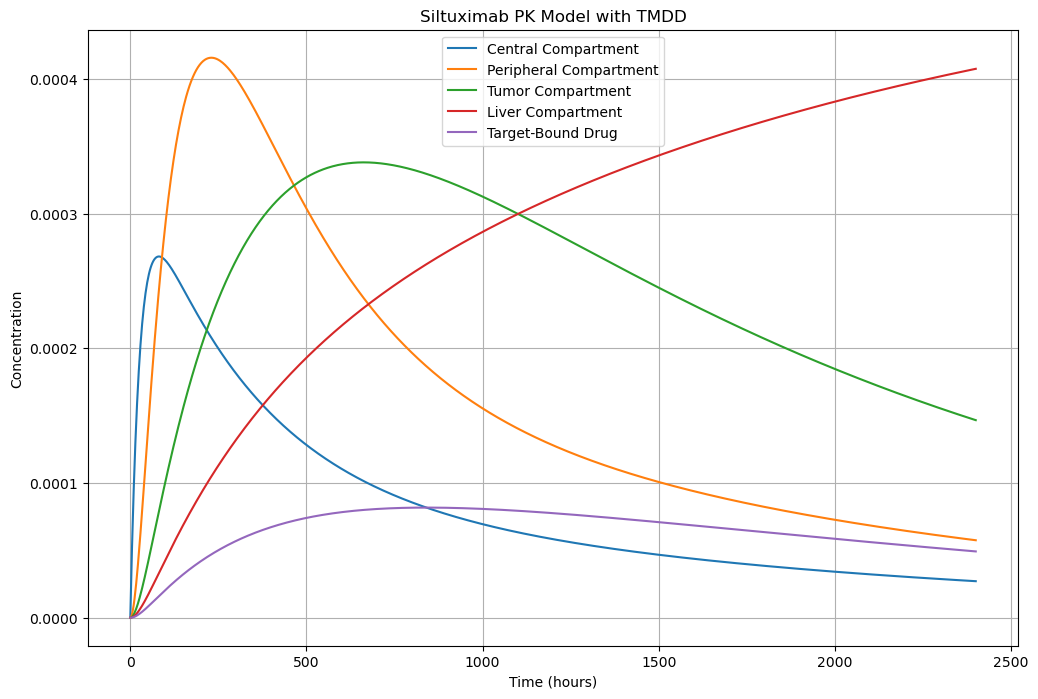

In [7]:
t = np.linspace(0, 2400, 1000)  # Simulate over 48 hours with fine resolution
# Initial conditions: [Dosing, Central, Peripheral, Tumor, Liver, Target-bound]
IL6_concentration = 1e-9  # Initial IL-6 concentration [mol/L]
y0_tmdd = [dose_moles, 0, 0, 0, 0, 0]  # Initial conditions

# Solve ODE with TMDD
solution_tmdd = odeint(pk_model_tmdd, y0_tmdd, t,
                       args=(k_ABS, k_CP, k_PC, k_Celim, k_CT, k_TC, k_CL, k_TMEelim,
                             1e6, 1e-3, IL6_concentration),  # Example k_bind and k_diss
                       atol=1e-12, rtol=1e-9)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(t, solution_tmdd[:, 1], label='Central Compartment')
plt.plot(t, solution_tmdd[:, 2], label='Peripheral Compartment')
plt.plot(t, solution_tmdd[:, 3], label='Tumor Compartment')
plt.plot(t, solution_tmdd[:, 4], label='Liver Compartment')
plt.plot(t, solution_tmdd[:, 5], label='Target-Bound Drug')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration')
plt.title('Siltuximab PK Model with TMDD')
plt.legend()
plt.grid(True)
plt.show()